In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import glob
import time
from sklearn.metrics import accuracy_score
# np.random.seed(30)

In [2]:
# mapping categories to integers
category_dict = {'Forest':0, 'Bedroom':1, 'Office':2, 'Highway':3, 'Coast':4, 'InsideCity':5,
               'TallBuilding':6, 'Industrial':7, 'Street':8, 'LivingRoom':9, 'Suburb':10,
               'Mountain':11, 'Kitchen':12, 'OpenCountry':13, 'Store':14}

In [3]:
def load_imgs(path, resize_small=False):
    start = time.time()
    global category_dict
    join_path = os.path.join(path, '*')
    class_path = glob.glob(join_path, recursive=True)
    cls = [path.split('/')[-1] for path in class_path]
    
    cls_path = []  # get the path of the images for all classes

    for c in cls:
        cls_path.append(glob.glob(os.path.join(path, c, '*.jpg'), recursive=True))
    
    imgs = []
    labels = []
    cls_names = []
    
    for cls_p in cls_path:
        img = []
        cls_name = cls_p[0].split('/')[-2]
        cls_names += [cls_name] * len(cls_p)
        labels += [category_dict[cls_name]] * len(cls_p)
        for img_path in cls_p:
            tmp_img = cv2.imread(img_path, 0)
            (h,w) = tmp_img.shape[:2]
            if(h>w):
                tmp_img= tmp_img[int(h/2)-int(w/2):int(h/2)+int(w/2),:]
            elif(h<w):
                tmp_img= tmp_img[:,int(w/2)-int(h/2):int(w/2)+int(h/2)]
            else:   
                tmp_img=tmp_img
            
                
            if resize_small:
                tmp_img = cv2.resize(tmp_img, dsize=(16, 16))
            else:
                tmp_img = cv2.resize(tmp_img, dsize=(256, 256))  # resize to equal-size
            img.append(tmp_img.flatten())
        imgs += img
        
    
    end = time.time()
    print("It takes", end-start, "seconds to load the images.")
    
    return np.array(imgs).astype(np.float32), np.array(labels).astype(np.float32).reshape(-1, 1), np.array(cls_names)


In [4]:
def show_img(X, cls, cls_num=15, size=16, nrows=3, ncols=5):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    for i in range(cls_num):
        x = i // ncols
        y = i % ncols
        ax[x][y].set_title(cls[i])
        ax[x][y].imshow(X[i].reshape(size, size), cmap='gray')

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.6)

In [5]:
def shuffle_data(X, y, cls=None):
    """
    Shuffle X, y together.
    """
    p = np.random.permutation(len(X))
    
    if cls is None:
        return X[p], y[p]
    else:
        return X[p], y[p], cls[p]

In [6]:
def predict(X_train, y_train, x_test, k):
    # create list for distances and targets
    distances = []
    targets = []

    for i in range(len(X_train)):
        # first we compute the euclidean distance
        distance = np.sqrt(np.sum(np.square(x_test - X_train[i, :])))
        # add it to list of distances
        distances.append([distance, i])

    # sort the list
    distances = sorted(distances)
    # make a list of the k neighbors' targets
    for i in range(k):
        index = distances[i][1]
        targets.append(int(y_train[index]))
    result = np.bincount(targets).argmax()

    # return most common target
    return result 


def kNearestNeighbor(X_train, y_train, X_test, predictions, k):
    # check if k larger than n
    if k > len(X_train):
        raise ValueError

    # predict for each testing observation
    for i in range(len(X_test)):
        predictions.append(predict(X_train, y_train, X_test[i, :], k))

def get_best_k(X_train, y_train, X_test, y_test):
    accs=[]
    for i in range(1, 50):
        predictions = []
        try:
            kNearestNeighbor(X_train, y_train, X_test, predictions, k=i)
            predictions = np.asarray(predictions).reshape(-1, 1)
            # evaluating accuracy
            accs.append((y_test == predictions).mean() * 100)

        except ValueError:
            print('Can\'t have more neighbors than training samples!!')

    best_k = np.argmax(np.array(accs))
    print('best k:', best_k + 1, ', acc:', accs[best_k])
    plt.plot(range(1, 50), accs)
    plt.title("Nearest neighbor number v.s. accuracy")
    plt.xlabel("Nearest Neighbor Number (K)")
    plt.ylabel("Accuracy (%)")
    plt.show()

## Tiny image representation + nearest neighbor classifier
- ref: [knn opencv](https://docs.opencv.org/3.4/d5/d26/tutorial_py_knn_understanding.html)

It takes 1.967472791671753 seconds to load the images.
It takes 0.20250606536865234 seconds to load the images.


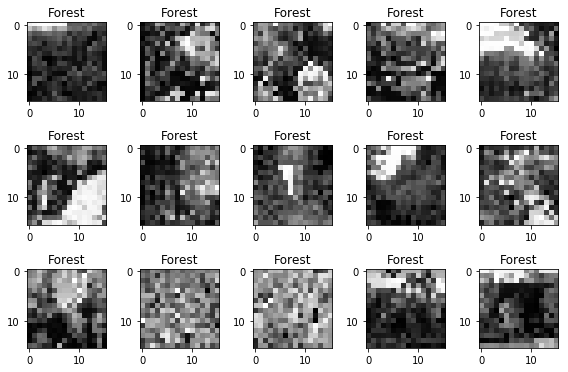

In [7]:
resize_small = True
X_train, y_train, cls_train = load_imgs('./data/train', resize_small=resize_small)
X_test, y_test, cls_test = load_imgs('./data/test', resize_small=resize_small)
# X_train, y_train, cls_train = shuffle_data(X_train, y_train, cls_train)
if resize_small:
    show_img(X_train, cls_train, size=16)
else:
    show_img(X_train, cls_train, size=256)

best k: 1 , acc: 18.0


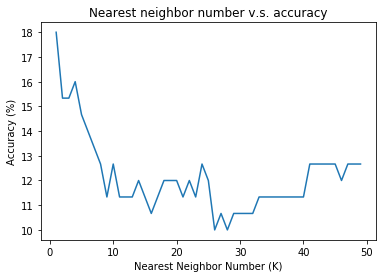

In [8]:
get_best_k(X_train, y_train, X_test, y_test)

## Bag of SIFT representation + nearest neighbor classifier
ref:
- [bow_github](https://github.com/techfort/pycv/blob/master/chapter7/bow.py)
- [bow_tutorial](http://www.morethantechnical.com/2011/08/25/a-simple-object-classifier-with-bag-of-words-using-opencv-2-3-w-code/)
- [gilscv_blog: BOW algorithm](https://gilscvblog.com/2013/08/23/bag-of-words-models-for-visual-categorization/)
- [kmeans clustering from scratch using python](http://madhugnadig.com/articles/machine-learning/2017/03/04/implementing-k-means-clustering-from-scratch-in-python.html)

## Bag of SIFT representation + linear SVM classifier

In [9]:
import sys
sys.path.insert(0, "./libsvm/python")
from svmutil import *

In [10]:
def transform_format(X, y, filename):
    """
    Transform the format of data into libsvm-acceptable format.
    Data format: file
        <label> <index1>:<value1> <index2>:<value2> ...
        Each line contains an instance and is ended by a '\n' character.
    """
    y_unique = np.unique(y).astype(int)
    with open(filename, 'w') as f:
        for n in range(X.shape[0]):
            f.write(str(int(y[n])))  # label
            for d in range(X.shape[1]):
                f.write(' ' + str(d+1) + ':' + str(X[n][d]))
            f.write('\n')

In [11]:
def svm(X_train, y_train, X_test, y_test, param):
    transform_format(X_train, y_train, 'train.txt')
    transform_format(X_test, y_test, 'test.txt')
    y_train, X_train = svm_read_problem('./train.txt')
    y_test, X_test = svm_read_problem('./test.txt')
                     
    m = svm_train(y_train, X_train, param)  # get the model of svm
    p_label, p_acc, p_val = svm_predict(y_test, X_test, m)

In [12]:
# https://docs.opencv.org/2.4/modules/features2d/doc/object_categorization.html
class BOWImgDescriptorExtractor:
    """
    BOWImgDescriptorExtractor: Compute an image descriptor using the bag of visual words.
    """
    def __init__(self, dextractor, dmatcher):
        self.dextractor = dextractor
        self.dmatcher = dmatcher
        self.vocabulary = None
        self.desSize = 0
        self.desType = None
    
    def setVocabulary(self, vocabulary):
        self.vocabulary = vocabulary
    
    def getVocabulary(self):
        return self.vocabulary
    
    def compute(self, img, kp):
        # Computes an image descriptor using the set visual vocabulary.
        if self.vocabulary is None:
            print('Hasn\'t set the vocabulary yet.')
            return
        des = self.dextractor.compute(img, kp)[1]
        self.desSize = des.shape[0]
        self.desType = type(des)

        # For each descriptor, compute its the nearest neighbor.
        # Build a histogram of length k where the i’th value is the frequency of the i’th dictionary word.
        histogram = np.zeros(self.vocabulary.shape[0])
        for d in des:
            distance = [np.sqrt(np.sum((d-v)**2)) for v in self.vocabulary]
            argmin = np.argmin(distance)
            histogram[argmin] += 1
        
        # do normalization
        histogram = histogram / len(histogram)
        
        return histogram
    
    def descriptorSize(self):
        return self.desSize

    def descriptorType(self):
        return self.desType

In [13]:
class BOWKMeansTrainer:
    """
    Using KMeans to cluster descriptors in order to find the representative vocabularies.
    # TODO: tolerence
    """
    def __init__(self, k=3, tolerance = 0.5, max_iterations = 10):
        self.k = k
        self.tolerance = tolerance
        self.max_iterations = max_iterations
        self.descriptor = []
    
    def add(self, des):
        """
        add descriptors.
        """
        self.descriptor.extend(des)
    
    def cluster(self, seed=30):
        """
        Do clustering using kmeans on the descriptors.
        ------
        return:
            The center of each cluster as vocabularies.
        """
        np.random.seed(30)
        self.descriptor = np.array(self.descriptor)
        
        # Choose k centroid
        index = np.random.choice(len(self.descriptor), self.k)
        centroid = [self.descriptor[idx] for idx in index]
        centroid_old = centroid.copy()
        for i in range(self.max_iterations):
            start = time.time()
            # Calculate the Euclidean distance of every points to each centroid.
            cls = []
            for d in self.descriptor:
                distance = [np.sqrt(np.sum((d-c)**2)) for c in centroid]
                cls.append(np.argmin(distance))
            cls = np.array(cls)
            
            # compute new centroid using the average of data in same class.
            centroid = []
            for j in range(self.k):
                descriptors = self.descriptor[cls==j]
                if not descriptors.any():
                    # no points belongs to this group.
                    index = np.random.choice(len(self.descriptor), 1)
                    centroid.append(self.descriptor[index])
                else:
                    centroid.append(np.mean(descriptors, axis=0))
            
            loss = [abs(centroid_old[i] - centroid[i]) for i in range(self.k)]
            loss_mean = np.mean(np.array(loss))
            end = time.time()
            print('It takes', end-start, 'seconds for this iteration. Loss:', loss_mean)
            if loss_mean < self.tolerance:
                break
            centroid_old = centroid.copy()
        # return centroid as vocabularies
        return np.array(centroid)

In [14]:
def bow(X_train, X_test, build_voc, k, max_iterations):    
    if build_voc:
        img_size = 256
        X_train = X_train.astype(np.uint8).reshape(X_train.shape[0], img_size, img_size).copy()
        X_test = X_test.astype(np.uint8).reshape(X_test.shape[0], img_size, img_size).copy()

        detect = cv2.xfeatures2d.SIFT_create()
        extract = cv2.xfeatures2d.SIFT_create()

        bow_trainer = BOWKMeansTrainer(k=k, max_iterations=max_iterations)
        
        for x in X_train:
            des = extract.compute(x, detect.detect(x))[1]
            bow_trainer.add(des)

        v = bow_trainer.cluster()
        np.save('voc_' + str(k), v)
        print('Finish building vocabulary')
        
        flann_params = dict(algorithm = 1, trees = 5)      # flann enums are missing, FLANN_INDEX_KDTREE=1
        matcher = cv2.FlannBasedMatcher(flann_params, {})  # need to pass empty dict (#1329)

        bow_extract = BOWImgDescriptorExtractor(extract, matcher)
        bow_extract.setVocabulary(v)
        train = []
        test = []
        for x in X_train:
            train.append(bow_extract.compute(x, extract.detect(x)))

        for x in X_test:
            test.append(bow_extract.compute(x, extract.detect(x)))

        train = np.array(train)
        test = np.array(test)
        np.save('train_' + str(k), train)
        np.save('test_' + str(k), test)

    else:
        v = np.load('voc_' + str(k) + '.npy')
        train = np.load('train_' + str(k) + '.npy')
        test = np.load('test_' + str(k) + '.npy')
    
    return train, test

It takes 2.2510342597961426 seconds to load the images.
It takes 0.2219688892364502 seconds to load the images.
best k: 17 , acc: 49.3333333333


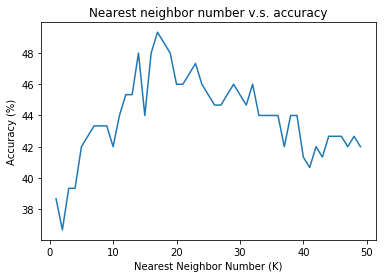

In [15]:
resize_small = False
X_train, y_train, cls_train = load_imgs('./data/train', resize_small=resize_small)
X_test, y_test, cls_test = load_imgs('./data/test', resize_small=resize_small)
X_train, X_test = bow(X_train, X_test, build_voc=False, k=256, max_iterations=10)
X_train, y_train = shuffle_data(X_train, y_train)

get_best_k(X_train, y_train, X_test, y_test)

In [27]:
sys.path.insert(0, "./libsvm/tools/")
from grid import *

resize_small = False
ks = [32, 64, 128, 256]
best_param = []
for k in ks:
    X_train, y_train, cls_train = load_imgs('./data/train', resize_small=resize_small)
    X_test, y_test, cls_test = load_imgs('./data/test', resize_small=resize_small)
    print("vocabulary size:", k)
    X_train, X_test = bow(X_train, X_test, build_voc=False, k=k, max_iterations=10)
    X_train, y_train = shuffle_data(X_train, y_train)
    
    transform_format(X_train, y_train, 'train.txt')
    transform_format(X_test, y_test, 'test.txt')
    
    rate, param = find_parameters('./train.txt', '-log2c -2,3,1 -log2g null')
    best_param.append(param)
    print(rate)
    print(param)

It takes 2.1159870624542236 seconds to load the images.
It takes 0.20113897323608398 seconds to load the images.
vocabulary size: 32
[local] 1.0 48.7333 (best c=2.0, rate=48.7333)
[local] -1.0 49.2667 (best c=0.5, rate=49.2667)
[local] 3.0 46.7333 (best c=0.5, rate=49.2667)
[local] -2.0 48.5333 (best c=0.5, rate=49.2667)
[local] 2.0 47.5333 (best c=0.5, rate=49.2667)
[local] 0.0 49.1333 (best c=0.5, rate=49.2667)
0.5 49.2667
49.2667
{'c': 0.5}
It takes 2.280978202819824 seconds to load the images.
It takes 0.20275187492370605 seconds to load the images.
vocabulary size: 64
[local] 1.0 52.2667 (best c=2.0, rate=52.2667)
[local] -1.0 47.0667 (best c=2.0, rate=52.2667)
[local] 3.0 52.6667 (best c=8.0, rate=52.6667)
[local] -2.0 43.0 (best c=8.0, rate=52.6667)
[local] 2.0 52.8667 (best c=4.0, rate=52.8667)
[local] 0.0 50.3333 (best c=4.0, rate=52.8667)
4.0 52.8667
52.8667
{'c': 4.0}
It takes 2.2567670345306396 seconds to load the images.
It takes 0.21141982078552246 seconds to load the ima

In [28]:
for param in best_param:
    X_train, y_train, cls_train = load_imgs('./data/train', resize_small=resize_small)
    X_test, y_test, cls_test = load_imgs('./data/test', resize_small=resize_small)
    X_train, X_test = bow(X_train, X_test, build_voc=False, k=k, max_iterations=10)
    X_train, y_train = shuffle_data(X_train, y_train)
    svm(X_train, y_train, X_test, y_test, "-t 0 -c " + str(param['c']))

It takes 2.2832648754119873 seconds to load the images.
It takes 0.26172304153442383 seconds to load the images.
Accuracy = 22.6667% (34/150) (classification)
It takes 2.1321022510528564 seconds to load the images.
It takes 0.2041606903076172 seconds to load the images.
Accuracy = 44% (66/150) (classification)
It takes 2.2963569164276123 seconds to load the images.
It takes 0.20407605171203613 seconds to load the images.
Accuracy = 53.3333% (80/150) (classification)
It takes 2.028048276901245 seconds to load the images.
It takes 0.20476174354553223 seconds to load the images.
Accuracy = 54% (81/150) (classification)
